# Generate ~1500 intermediate sequences between VIM-2 and NDM-1 

## Upload code and data

In [1]:
# import Julia packages

using Pkg
using KitMSA
using StatsBase
using PyPlot
using PyCall
using DelimitedFiles
using BenchmarkTools
using Suppressor
using Statistics

hamming(seq1, seq2) =  KitMSA.my_hamming(seq1, seq2)
;

[ Info: Precompiling Suppressor [fd094767-a336-5f1f-9728-57cf17d0bbfb]


In [12]:
# translate ordered list of residues to paths of sequences
function path2seq(seq_start::Array{Int16, 1}, seq_end::Array{Int16, 1}, path_muts::Array{Int16, 1})
    
    M = length(path_muts)
    L = length(seq_start)

    path_seq = Int16.(zeros(M+1, L))
    path_seq[1, :] = seq_start
    
    for i in 1:M
        ss = copy(path_seq[i, :])
        res = path_muts[i]
        ss[res] = seq_end[res]
        path_seq[i+1, :] = ss
    end
    
    return path_seq   
end

# save to file non aligned sequences adding VIM2 terminal
function dealign_and_save_VIM2_NDM1_intermediates(path_in)
    
    VIM2_Nterm = "mfkllskllvyltasimaiasplafsvdssgeyptvseipv"
    VIM2_Cterm = "tnrsvve"

    MSA = fasta2matrix(path_in)
    M, L = size(MSA)
    desc = readlines(path_in)[1:4:end]
    path_out = path_in * "_full_sequence"
    
    open(path_out, "w") do file
        for m in 1:M
            seq = MSA[m, :]
            seq_string = join(num2letter.(seq))
            #seq_nog = join([seq_string[i] for i in 1:L if seq_string[i] != "-" ])
            seq_chimera = VIM2_Nterm * seq_string * VIM2_Cterm
            println(file, ">$(m) $(desc[m][4:end])")
            println(file, seq_chimera)
        end
    end
end

function meanE_path(seq_start::Array{Int16, 1}, seq_end::Array{Int16, 1},       
        h::Array{Float64, 2}, J::Array{Float64, 4};  β::Real = 1, steps::Int64 = 100)
    
    # set of non common positions (including gaps)
    not_common = [i for (i, amino) in enumerate(seq_end) if seq_start[i] != amino]
    
    # length of non common position
    L_not_common = length(not_common)

    # initialize path
    old_path_muts = Int16.(sample(not_common, L_not_common, replace = false))
    
    # index for iterations
    k = 0
    
    while k < steps
        
        # add 1 to iteration index
        k += 1
        
        # new path
        new_path_muts = copy(old_path_muts)   
        
        # mutations to swap
        pos_res1, pos_res2 = sample(1:L_not_common, 2, replace = false)
        
        # introduce mutations in new path
        new_path_muts[pos_res1] = old_path_muts[pos_res2]
        new_path_muts[pos_res2] = old_path_muts[pos_res1]
        
        # build new trajectory
        new_path_seq = path2seq(seq_start, seq_end, new_path_muts)
        
        # build trajectory from the mutation's order
        old_path_seq = path2seq(seq_start, seq_end, old_path_muts)

        # compute energy of new trajectory 
        delta_en = mean([delta_energy(h, J, new_path_seq[i, :], old_path_seq[i, :]) for i in 1:(L_not_common+1) ])

        # metropolis acceptance rule
        if min(1, exp( -β* (delta_en) )) > rand()
            old_path_muts = new_path_muts
        end   
        
    end
    
    return old_path_muts
end


function sample_n_paths(h, J, npath; n_steps = 5000, β = 5)

    # non common residue between VIM2 and NDM1
    not_common_residues = [i for (i, amino) in enumerate(VIM2) if NDM1[i] != amino]
    L = length(not_common_residues)

    # initialize 3 paths
    mutations_rand = Int16.(sample(not_common_residues, L, replace = false))
    paths_meanE_vec = [path2seq(VIM2, NDM1, mutations_rand) for i in 1:npath]

    # initialize energy of the path
    e_meanE_vec = [zeros(L + 1) for i in 1:npath]

    # generate 2 paths
    for i in 1:npath
        @time final_muts = meanE_path(VIM2, NDM1, h, J, β = β, steps = n_steps) 
        paths_meanE_vec[i] = path2seq(VIM2, NDM1, final_muts)
        e_meanE_vec[i] = energy(h, J, paths_meanE_vec[i])
    end
    return paths_meanE_vec
end


function sample_n_paths(h, J, npath; n_steps = 5000, β = 5)

    # non common residue between VIM2 and NDM1
    not_common_residues = [i for (i, amino) in enumerate(VIM2) if NDM1[i] != amino]
    L = length(not_common_residues)

    # initialize 3 paths
    mutations_rand = Int16.(sample(not_common_residues, L, replace = false))
    paths_meanE_vec = [path2seq(VIM2, NDM1, mutations_rand) for i in 1:npath]

    # initialize energy of the path
    e_meanE_vec = [zeros(L + 1) for i in 1:npath]

    # generate 2 paths
    for i in 1:npath
        @time final_muts = meanE_path(VIM2, NDM1, h, J, β = β, steps = n_steps) 
        paths_meanE_vec[i] = path2seq(VIM2, NDM1, final_muts)
        e_meanE_vec[i] = energy(h, J, paths_meanE_vec[i])
    end
    return paths_meanE_vec
end


function plot_paths(h, J, path)
    npath = length(paths)
    e_meanE_vec = [energy(h, J, paths[i]) for i in 1:npath]

    plt.figure(figsize = (8, 6))

    for i in 1:npath
        for (k , dist) in enumerate(intermediate_line)
            plt.axvline(x=dist, linewidth = 0.5, ;linestyle = "-.", color = "black", alpha = 0.5)
            if i == 1
                plt.text(dist - 3, minimum(e_meanE_vec[i]), "$(fraction_line[k])%", fontsize = 8)
            end
        end

        plt.plot(collect(0:HD), e_meanE_vec[i], 
            linewidth = 0.8, marker = "o", markersize = 2, label = "Path $(i), β  = $(β), MCsteps = $(n_steps)")

        plt.scatter(intermediate_d, e_meanE_vec[i][intermediate_d .+ 1], color = "black", s = 20)

        if i == 1
            plt.scatter([0], [e_meanE_vec[i][1]], color = "green", label = "VIM2")
            plt.scatter([HD], [e_meanE_vec[i][end]], color = "red", label = "NDM1")
        end

        plt.xlabel("Hamming distance from VIM-2", fontsize = 20)
        plt.ylabel("Energy", fontsize = 20)

    end
    plt.title("Mean energy", fontsize = 20)
    plt.legend()
end

function pairwise_hd(MSA)
    M, L = size(MSA)
    HD = zeros( Int64.(M * (M-1) / 2))
    k = 0
    for i in 1:(M-1)
        for j in (i+1):M
            k += 1
            HD[k] = hamming(MSA[i, :], MSA[j, :])
        end
    end
    return HD
end



pairwise_hd (generic function with 1 method)

In [3]:
# upload DCA model parameters
h, J = extract_params("../data/DCAparam/Parameters_B1all_YI.dat.gz")
;

In [10]:
# upload wild_types
VIM2 = fasta2matrix("../data/alignments/ref/alignments_struc_John_sym03/VIM2_V185I_equal_length_hmmstruct_symfrac03_max075flankcolgaps.fasta")
NDM1 = fasta2matrix("../data/alignments/ref/alignments_struc_John_sym03/NDM1_equal_length_hmmstruct_symfrac03_max075flankcolgaps.fasta")

# hamming distance between wildtypes
HD = hamming(VIM2, NDM1)

# intermediate distances between wildtypes

frac = 5/141
d_perc = collect(frac:frac:(1-frac))

d_perc_w_ext = copy(d_perc)
d_perc_w_ext = push!(pushfirst!(d_perc_w_ext, 0), 1)


intermediate_d = Int64.(round.(HD.*d_perc, digits = 0))
intermediate_line = Int64.(round.(HD.*d_perc_w_ext, digits = 0))
fraction_line = Int64.(round.(d_perc_w_ext .* 100, digits = 0))
;

## Generate 1700 sequences (mean energy)

#### Steps = 5000, $\beta$ = 5

Here we generate 8 sequences by producing 2 paths.

The 2 paths are obtained via MCMC sampling with a loss given by the mean energy of the path.
That is :

$E_{mean}$ = $\frac{1}{L} \sum_{i = 1}^{L} E(\sigma_{i})$

if $\sigma_k$ is the $k$th sequence of the path.

# ANALYSIS OF SEQUENCES

In [6]:
MSA_nat = fasta2matrix("../data/alignments/paths/nat/B1_all_Sevan_hmm03_max010rowgaps_max075flankcolgaps_max080wtid.fasta")
MSA_beta_2 = fasta2matrix("../data/alignments/paths/dropsynt/sample_VIM_NDM/final/path_meanE_beta_2")
MSA_beta_5 = fasta2matrix("../data/alignments/paths/dropsynt/sample_VIM_NDM/final/path_meanE_beta_5")
;

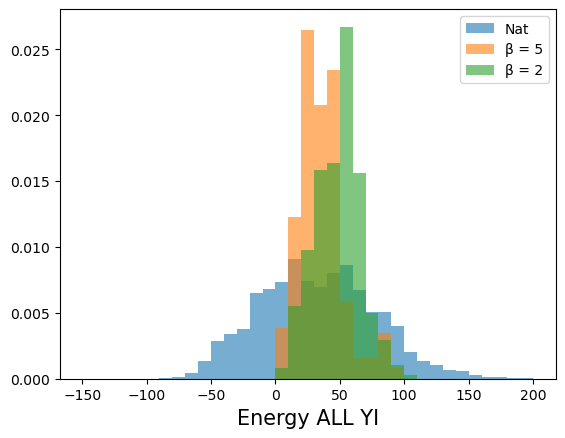

PyObject Text(0.5, 30.0, 'Energy ALL YI')

In [7]:
bb = collect(-150:10:200)
plt.hist(energy(h, J, MSA_nat), density = true, label = "Nat", alpha = 0.6, bins = bb)
plt.hist(energy(h, J, MSA_beta_5), density = true, label = "β = 5", alpha = 0.6, bins = bb)
plt.hist(energy(h, J, MSA_beta_2), density = true, label = "β = 2", alpha = 0.6, bins= bb)
plt.legend()
plt.xlabel("Energy ALL YI", fontsize = 15)
#plt.savefig("../plots/dropsynt/VIM-NDM_intermediates/energy_seqs_vs_nat", 
#    dpi = 300, bbox_inches = "tight")

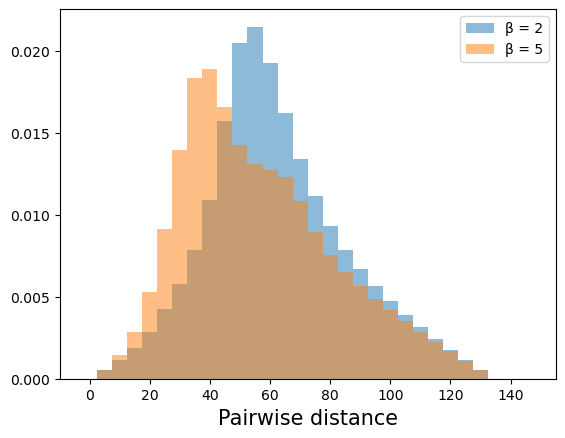

PyObject Text(0.5, 30.0, 'Pairwise distance')

In [13]:
bb = collect(-2.5:5:150)
plt.hist(pairwise_hd(MSA_beta_2), density = true, label = "β = 2", alpha = 0.5, bins = bb)
plt.hist(pairwise_hd(MSA_beta_5), density = true, label = "β = 5", alpha = 0.5, bins = bb)
plt.legend()
plt.xlabel("Pairwise distance", fontsize = 15)
#plt.savefig("../plots/dropsynt/VIM-NDM_intermediates/pairwise_distance", 
#    dpi = 300, bbox_inches = "tight")

In [36]:
fraction_li

29-element Array{Int64,1}:
   0
   4
   7
  11
  14
  18
  21
  25
  28
  32
  35
  39
  43
   ⋮
  60
  64
  67
  71
  74
  78
  82
  85
  89
  92
  96
 100

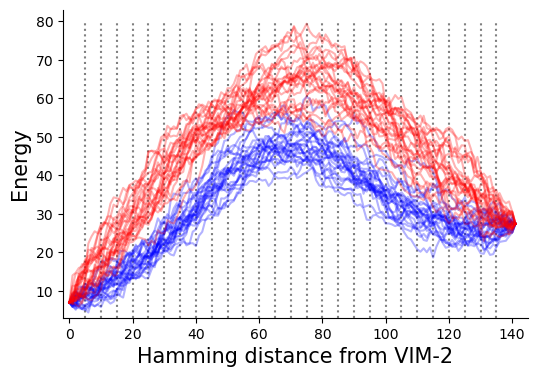

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

plt.xlim(-2, 145)
plt.ylim(3, 83)

for i in 1:25
    MSA = fasta2matrix("../data/alignments/paths/dropsynt/sample_VIM_NDM/full_paths/path_meanE_beta_5_n_$(i)")
    hd = [hamming(MSA[k, :], VIM2) for k in 1:size(MSA, 1)]
    e = energy(h, J, MSA)
    plt.plot(hd, e, color = "blue", alpha = 0.3, zorder = 2)
end

plt.vlines(intermediate_d, 0, 80, zorder = 0, linestyle = "dotted", color = "grey")

for i in 1:25
    MSA = fasta2matrix("../data/alignments/paths/dropsynt/sample_VIM_NDM/full_paths/path_meanE_beta_2_n_$(i)")
    hd = [hamming(MSA[k, :], VIM2) for k in 1:size(MSA, 1)]
    e = energy(h, J, MSA)
    plt.plot(hd, e, color = "red", alpha = 0.3, zorder = 2)
end

plt.xlabel("Hamming distance from VIM-2", fontsize = 15)
plt.ylabel("Energy", fontsize = 15)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
plt.savefig("../img/presentation/path_full_VIM-NDM", dpi = 300, bbox_inches = "tight")

# ANALYSIS OF THE ALGORITHM

  8.317306 seconds (8.56 M allocations: 8.134 GiB, 26.41% gc time)
  7.133514 seconds (8.56 M allocations: 8.134 GiB, 18.51% gc time)
  7.845383 seconds (8.56 M allocations: 8.134 GiB, 19.03% gc time)
  7.220409 seconds (8.56 M allocations: 8.134 GiB, 19.37% gc time)
  7.143560 seconds (8.56 M allocations: 8.134 GiB, 18.68% gc time)
  7.325994 seconds (8.56 M allocations: 8.134 GiB, 19.06% gc time)
  7.307968 seconds (8.56 M allocations: 8.134 GiB, 19.13% gc time)
  7.559924 seconds (8.56 M allocations: 8.134 GiB, 18.80% gc time)
  7.294867 seconds (8.56 M allocations: 8.134 GiB, 18.74% gc time)
  7.365718 seconds (8.56 M allocations: 8.134 GiB, 19.13% gc time)
  7.671744 seconds (8.56 M allocations: 8.134 GiB, 19.13% gc time)
  7.327839 seconds (8.56 M allocations: 8.134 GiB, 18.97% gc time)
  7.658744 seconds (8.56 M allocations: 8.134 GiB, 19.31% gc time)
  7.780352 seconds (8.56 M allocations: 8.134 GiB, 18.87% gc time)
  7.376986 seconds (8.56 M allocations: 8.134 GiB, 18.89% gc t

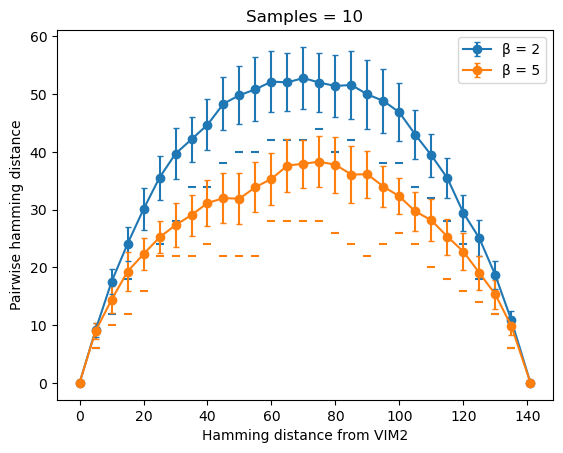

PyObject <matplotlib.legend.Legend object at 0x7fe7106cffd0>

In [14]:
fig = plt.figure()
npath = 10

for β in [2, 5]
    paths = sample_n_paths(h, J, npath, n_steps = 5000, β = β)
    average_d = zeros(length(intermediate_line))
    std_d = zeros(length(intermediate_line))
    min_d = zeros(length(intermediate_line))


    for (i, d) in enumerate(intermediate_line)
        MSA_same_d = zeros(Int64, npath , length(VIM2))
        for n in 1:npath
            MSA_same_d[n, :] = paths[n][d+1, :]
        end
        pd = pairwise_hd(MSA_same_d)
        average_d[i] = mean(pd)
        std_d[i] = std(pd)
        min_d[i] = minimum(pd)
    end

    plt.errorbar(intermediate_line, average_d, std_d, capsize = 2, marker = "o", label = "β = $(β)")
    plt.scatter(intermediate_line, min_d, marker = "_")
end
plt.title("Samples = $(npath)")
plt.xlabel("Hamming distance from VIM2")
plt.ylabel("Pairwise hamming distance")
plt.legend()
#plt.savefig("../plots/dropsynt/pairwise_d_YI_example", bbox_inches = "tight", dpi =300)

### Average energy

  7.594739 seconds (8.56 M allocations: 8.134 GiB, 21.11% gc time)
  7.678248 seconds (8.56 M allocations: 8.134 GiB, 21.03% gc time)
  7.880535 seconds (8.56 M allocations: 8.134 GiB, 21.40% gc time)
  8.116311 seconds (8.56 M allocations: 8.134 GiB, 21.16% gc time)
  7.953298 seconds (8.56 M allocations: 8.134 GiB, 20.93% gc time)
  7.861857 seconds (8.56 M allocations: 8.134 GiB, 21.44% gc time)
  7.723924 seconds (8.56 M allocations: 8.134 GiB, 21.01% gc time)
  7.594390 seconds (8.56 M allocations: 8.134 GiB, 20.72% gc time)
  7.460008 seconds (8.56 M allocations: 8.134 GiB, 20.83% gc time)
  

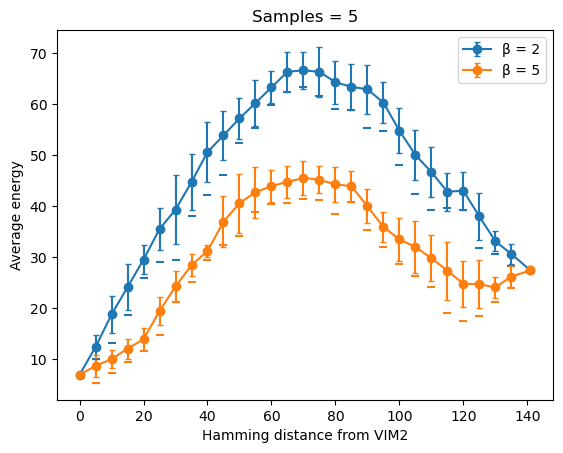

7.435934 seconds (8.56 M allocations: 8.134 GiB, 21.10% gc time)


In [25]:
fig = plt.figure()
npath = 5

for β in [2, 5]
    paths = sample_n_paths(h, J, npath, n_steps = 5000, β = β)
    average_e = zeros(length(intermediate_line))
    std_e = zeros(length(intermediate_line))
    min_e = zeros(length(intermediate_line))

    for (i, d) in enumerate(intermediate_line)
        MSA_same_d = zeros(Int64, npath , length(VIM2))
        for n in 1:npath
            MSA_same_d[n, :] = paths[n][d+1, :]
        end
        ens = energy(h, J, MSA_same_d)
        average_e[i] = mean(ens)
        std_e[i] = std(ens)
        min_e[i] = minimum(ens)
    end

    plt.errorbar(intermediate_line, average_e, std_e, capsize = 2, marker = "o", label = "β = $(β)")
    plt.scatter(intermediate_line, min_e, marker = "_")
end
plt.title("Samples = $(npath)")
plt.xlabel("Hamming distance from VIM2")
plt.ylabel("Average energy")
plt.legend()
#plt.savefig("../plots/dropsynt/VIM-NDM_intermediates/energy_YI_example", bbox_inches = "tight", dpi =300)